In [ ]:
import os
import datetime
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/My Drive/Reinforcement Learning')
# !ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
import scipy.integrate as integral
import time
from scipy.io import savemat,loadmat
import matplotlib.pyplot as plt
import os
import math
import torch as T
from torch.fft import fft2,ifft2,ifftshift,fftshift
from numba import njit, prange
from tqdm import tqdm
import cv2
import warnings
from matplotlib import style
from scipy.stats import skew,kurtosis
warnings.filterwarnings('ignore')

In [ ]:
# np.random.seed(42)
# T.manual_seed(42)

In [ ]:
global device
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
print('Using ', device)

Using  cuda:0


In [ ]:
def Transverse_ph_abbrZP(abr,th,rh,R):
  s = time.time()
  rho = T.tensor(rh/R).to(device)
  th = T.tensor(th).to(device)
  abr = T.tensor(abr).to(device)
  ZP1 = 2*rho*T.sin(th)
  ZP2 = 2*rho*T.cos(th)

  ZP3 = np.sqrt(3)*(2*(rho**2)-1)

  ZP4 = np.sqrt(6)*(rho**2*T.sin(2*th))
  ZP5 = np.sqrt(6)*(rho**2*T.cos(2*th))

  ZP6 = np.sqrt(8)*((3*rho**3 - 2*rho)*T.sin(th))
  ZP7 = np.sqrt(8)*((3*rho**3 - 2*rho)*T.cos(th))

  ZP8 = np.sqrt(8)*(rho**3*T.sin(3*th))
  ZP9 = np.sqrt(8)*(rho**3*T.cos(3*th))

  ZP10 = np.sqrt(5)*(6*(rho**4)-6*(rho**2)+1)

  ZPt = abr[0]*ZP1 + abr[1]*ZP2 + abr[2]*ZP3 + abr[3]*ZP4 +\
      abr[4]*ZP5 + abr[5]*ZP6 + abr[6]*ZP7 + abr[7]*ZP8 +\
            abr[8]*ZP9 + abr[9]*ZP10
  ZPt[rho>1] = 0
  AbPh = T.exp(1j*2*np.pi*ZPt)
  e = time.time()-s
  # print('Transverse_ph_abbrZP:',str(e),'s')
  return AbPh


def cart2pol(x, y):
  # print("cart2pol")
  rho = np.sqrt(x**2 + y**2)
  phi = np.arctan2(y, x)
  return phi, rho

def GaussBeamNDefPsLw(lambda_,w0,Rc,X0,Y0,Dxy,NP,m,zmm):

  s = time.time()
  k = 2*np.pi/lambda_
  zR = np.pi*w0**2/lambda_
  z = zmm*1000

  M = NP
  dx = Dxy/M
  x = T.arange((-M/2 - X0)*dx, (M/2 - X0)*dx,dx).to(device)

  N=NP
  dy = Dxy/N
  y = T.arange((-N/2 - Y0)*dy, (N/2 - Y0)*dy,dy).to(device)

  [X,Y] = T.meshgrid(x,y,indexing='xy')


  R = T.sqrt(X**2+Y**2)#.to(device)
  # phy = T.arctan2(Y,X).to(device)

  P = 0.01
  A = (2*P)/(np.pi*(w0*1e-3)**2)
  C = np.sqrt(A)*T.exp(1j*k*(R**2)/(2*Rc)).to(device)

  Psi = C*T.exp(-(R**2)/(w0**2))#*T.exp(1j*m*phy)
  uout = Psi
  e = time.time()-s
  # print('Gaussian_beam: ',str(e),'s')
  return uout

def CirAperN(X1,Y1,Ra,Dx,NP):
  s = time.time()
  M = NP
  dx = Dx/M
  x = T.arange((-M/2 - X1)*dx, (M/2 - X1)*dx,dx).to(device)
  N=NP
  dy = Dx/N
  y = T.arange((-N/2 - Y1)*dy, (N/2 - Y1)*dy,dy).to(device)
  [X,Y] = T.meshgrid(x,y,indexing='xy')
  s = time.time()
  A = T.ones(X.shape,dtype=T.int16).to(device)
  # A = T.tensor(np.ones(X.shape,dtype=np.float32)).to(device)
  e = time.time()-s
  # print('CirAperN: ',str(e),'s')
  r = Ra
  R = T.sqrt(X**2+Y**2)
  A[R>r] = 0
  e = time.time()
  return A


def rectangularPulse(start,stop,x):
  s = time.time()
  pulse = []
  for i in x:
    if start<i and stop>i:
        val = 1
    elif i==stop or i==start:
        val = 0.5
    else:
        val = 0
    pulse.append(val)
  pulse = np.array(pulse)
  e = time.time() - s
  # print('rectangularPulse: ',str(e),'s')
  return pulse

@njit(parallel=True,fastmath=True)
def get_gamma(len_alpha,len_beta,alpha,beta):
  gamma = np.zeros((len_alpha,len_beta))
  for j in prange(len_beta):
    for i in prange(len_alpha):
      if alpha[i]**2 + beta[j]**2 > 1:
        gamma[j,i] = 0
      else:
        gamma[j,i] = np.sqrt(1-alpha[i]**2-beta[j]**2)
  return gamma

@njit(parallel=True,fastmath=True)
def getFs(FxBL,FxBLr,FyBL,FyBLc,c,r):
  for i in prange(c):
    FxBL[i,0:r] = FxBLr
  for j in prange(r):
    FyBL[0:c,j] = FyBLc
  return FxBL,FyBL

def PropAngSpecBandLimF(uin,L,Dx,Dy,zmm):
  start = time.time()
  layer = uin
  # layer1 = T.tensor(layer).to(device)
  lambda_ = L*1e-3
  k = 2*np.pi/lambda_
  z = zmm*1e-3
  phy_x = Dx*1e-3
  phy_y = Dy*1e-3

  obj_size = layer.shape
  r,c = layer.shape[0], layer.shape[1]
  Fs_x = obj_size[1]/phy_x
  Fs_y = obj_size[0]/phy_y

  dFx = Fs_x/obj_size[1]
  dFy = Fs_y/obj_size[0]

  Fx = np.arange(-Fs_x/2,Fs_x/2,dFx)
  Fy = np.arange(-Fs_y/2,Fs_y/2,dFy)

  alpha = lambda_*Fx
  beta = lambda_*Fy
  len_alpha = len(alpha)
  len_beta = len(beta)

  gamma = get_gamma(len_alpha,len_beta,alpha,beta)


  ival = T.tensor(k*gamma*z).to(device)
  H0 = T.exp(1j*ival)

  Fxlim = 1/(np.sqrt(1+(2*dFx*z)**2)*lambda_)
  Fylim = 1/(np.sqrt(1+(2*dFy*z)**2)*lambda_)

  FxBL = np.zeros((len(beta),len(alpha)))
  FyBL = np.zeros((len(beta), len(beta)))
  FxBLr = rectangularPulse(-Fxlim,Fxlim,Fx)
  FyBLc = rectangularPulse(-Fxlim,Fylim,Fx)

  FxBL,FyBL = getFs(FxBL,FxBLr,FyBL,FyBLc,c,r)

  end = time.time()-start
  # print('Prop time: ', str(end))
  FxBL = T.tensor(FxBL).to(device)
  FyBL = T.tensor(FyBL).to(device)
  H1 = H0*FxBL*FyBL
  # dic={'H1':H1.cpu().numpy()}
  # savemat('psf.mat',dic)
  uout = ifft2(ifftshift((fftshift(fft2(layer)))*H1))

  return uout


def SphLens(uin,L1,L2,NP,lambda_,zf):
  #Units: mm

  k=2*np.pi/lambda_

  dy=L1/NP
  y=T.arange(-L1/2,L1/2,dy).to(device)

  dx=L2/NP
  x=T.arange(-L2/2,L2/2,dx).to(device)

  X,Y=T.meshgrid(x,y,indexing='xy')
  uout=T.multiply(uin,T.exp(-1j*(k/(2*zf))*(X**2+Y**2)))
  return uout

def sourceTAC_final(lambda_,w0,Ra,a,NL,Dx,NP,mDr,zm,m,Rc,phNs,Kvar,trans_pn,amp_v,g_amp, n_chan):

  k = 2*np.pi/lambda_
  xf = a/2
  yf = round(np.sqrt(3)*a/2)

  theta = mDr
  RN1 = np.random.randint(low=0,high=100,size=(36,))
  RN2 = np.random.randint(low=0,high=100,size=(36,))
  theta_rx = np.radians(theta*RN1/100)
  theta_ry = np.radians(theta*RN2/100)
  kx = k*np.sin(theta_rx)
  ky = k*np.sin(theta_ry)

  mnE = 2*NL+1

  zmm = zm*1000


  start = time.time()

  U = T.zeros(NP,NP)

  X0 = np.arange(-2*NL,2*NL+2,2, dtype=int)*int(xf)
  Y0 = int(0*yf)

  end = time.time()-start

  phNs1 = T.tensor(phNs)
  n_cn = 0

  uc0 = np.sqrt(g_amp)*GaussBeamNDefPsLw(lambda_,w0,Rc,0,0,Dx,NP,m,zmm)*CirAperN(0,0,Ra,Dx,NP)
  coord = np.array([])
  for r in range(mnE):
    coord = np.append(coord,[X0[r],Y0])

  p=1
  X1 = np.array([])
  Y1 = np.array([])
  while p <= NL:
    X1 = np.arange(-2*NL+p,2*NL-p+2,2, dtype=int)*int(xf)
    Y1 = int(p*yf)
    for q in range(mnE-p):
      coord = np.append(coord,[X1[q],Y1])
      coord = np.append(coord,[X1[q],-Y1])

    p += 1

  return uc0,coord

def get_ff(U,coord, noise):
  U_ = T.zeros_like(U).to(device)
  phNs = T.tensor(noise).to(device)
  for idx, c in enumerate(coord):
    U_ += T.roll(U,shifts=(c[0],c[1]),dims=(0,1))*T.exp(1j*phNs[idx])
  U_1 = U_.cpu().numpy()
  I=np.abs(U_1)**2
  return I

def TiledAperture_2(im_size,pix_size,n_channel,p_n,n_screens,Kvar,Z,trans_pn,atm,amp_v,g_amp,ra,d_):
  start = time.time()
  lambda_ = 1.064*1e-3
  Rc=1e15
  NP=im_size
  Dx=pix_size*NP
  m=0
  Ra= (ra/2)*1e3
  D=d_*1e3
  a=D*NP/Dx
  mDr=0
  w=0.85*Ra

  if n_channel == 7:
    NL=1
  elif n_channel == 19:
    NL = 2
  elif n_channel == 37:
    NL = 3
  elif n_channel == 61:
    NL = 4
  elif n_channel == 91:
    NL = 5
  elif n_channel == 127:
    NL = 6
  elif n_channel==217:
    NL=8
  else:
    ValueError('Please provide correct channel number..')

  zmm = Z*1e3
  zm = zmm*1e-3
  phNs = p_n
  n_step = n_screens
  zsmm = zmm/(n_step+1)
  w0 = w

  U,coord = sourceTAC_final(lambda_,w0,Ra,a,NL,Dx,NP,mDr,zm,m,Rc,phNs,Kvar,trans_pn,amp_v,g_amp,n_channel)
  U_ = U.cpu().numpy()
  # pib_ = PIB(np.abs(U_)**2,1024,1024,1023,pix_size)
  # print('Input Power: ', np.real(pib_))

  phy_x = Dx
  phy_y = Dx

  if atm is None:
    z_prop = zmm
  else:
    z_prop = zsmm
  Up = PropAngSpecBandLimF(U,lambda_,phy_x,phy_y,z_prop)  #final field z_prop


  if atm is not None:
    for ii in range(n_step):
      Uat = Up*T.exp(1j*atm[:,:,ii])
      Up = PropAngSpecBandLimF(Uat,lambda_,phy_x,phy_y,z_prop)

  Up_f = Up.cpu().numpy()
  Intf = np.abs(Up_f)**2

  end = time.time() - start
  # print("TAC: ", str(end))
  return U_,Up,coord.reshape(n_channel,2).astype(int)#U_,Up_f, np.real(Intf)

def random_walk(eps_len=100):
  fs = 1e6
  df = 2e6
  del_ = (2*np.pi*df)/fs
  del_phi = np.random.randn(1,eps_len)
  x = np.cumsum(del_phi * np.sqrt(del_))
  rw_t = np.zeros((7,eps_len))
  for i in range(7):
    rw_t[i] = np.roll(x,i)
  return rw_t

def env_pn(n_channel,cyc,delt):
  s = time.time()
  data = loadmat('./actor_critic/new_spline_fit.mat')
  env_t = data['env_t']
  env_1 = data['env_1']
  f = interp1d(env_t[:,0], env_1[:,0], kind='cubic')
  t_samp = np.arange(-10,-10+cyc,delt)
  env_n = f(t_samp)
  fft_env1 = fft(env_n)

  P1a = np.ones((n_channel,len(env_n)), dtype=np.cdouble)
  for ii in range(n_channel):
    P1a[ii,:] = ifft(fft_env1*np.exp(1j*2*np.pi*np.random.rand(1,len(env_n))))

  P1b = np.zeros((n_channel,len(env_n)))
  for ii in range(n_channel):
    P1b[ii,:] = (np.abs(P1a[ii,:])/np.mean(np.abs(P1a[ii,:])))-1

  P1b_ = np.abs(P1b)
  max_array = P1b_.max(axis=1)
  P1 = np.arccos(np.transpose(P1b)/max_array)
  e = time.time()-s
  # print('env_pn: ', str(e),'s')
  return P1

def ss_turb(im_size,N_ss,l_0,L_0,r_c):
  # start = time.time()
  n = np.arange(0,N_ss)

  kapp_0 = 2*np.pi/L_0
  kapp_m = 2*np.pi/l_0

  k_max = 2*kapp_m
  k_min = kapp_0

  K_n = k_min*np.exp((n/N_ss)*np.log(k_max/k_min))
  zeta = np.random.rand(1,len(list(K_n)))
  k_n = np.zeros((1,len(list(K_n))))
  k_n[0,0] = np.random.rand(1)

  for ii in range(1,len(list(K_n))):
      k_n[0,ii] = np.sqrt(K_n[ii-1]**2 + zeta[0,ii]*(K_n[ii]**2 - K_n[ii-1]**2))
  alp = 5/3
  c = (alp*2**(alp-2)*math.gamma(1+alp/2))/(np.pi*math.gamma(1-alp/2))
  func = lambda p: (p*c*r_c**(-alp)*np.exp(-p**2/kapp_m**2))/((p**2 + kapp_0**2)**(1+alp/2))
  phi = np.zeros((1,len(list(K_n))))

  phi[0,0],_ = integral.quad(func,K_n[0],K_n[1])
  for jj in range(1,len(list(K_n))):
      phi[0,jj],_ = integral.quad(func,K_n[jj-1],K_n[jj],epsrel=1.0e-3)

  alpha = np.random.randn(1,len(list(n)))
  beta = np.random.randn(1,len(list(n)))
  s_n = 2*np.pi*phi
  a_n = np.sqrt(s_n)*(alpha + 1j*beta)
  a = T.tensor(np.diag(np.transpose(a_n)[:,0])).to(device)
  theta = 2*np.pi*np.random.rand(1,len(list(n)))
  X = np.arange(0,1,1/im_size)
  Y = np.arange(0,1,1/im_size)
  X = X[:,np.newaxis]
  Y = Y[:,np.newaxis]
  x_n = T.tensor(np.exp(1j*X*(k_n*np.cos(theta)))).to(device)
  y_n = T.tensor(np.exp(1j*np.transpose(k_n*np.sin(theta))*np.transpose(Y))).to(device)

  si_n1 = T.matmul(x_n,a).to(device)
  si_n1 = T.matmul(si_n1,y_n).to(device)
  si_n = T.real(si_n1).to(device)
  # end = time.time() - start
  # print('ss_turb: ', str(end),'s')
  return si_n.cpu().clone().detach().numpy()

def PIB(uin,Xc, Yc,Roc,pix_size):
  s = time.time()
  sx,sy = uin.shape
  x = np.arange(sx)
  y = np.arange(sy)

  X,Y = np.meshgrid(x,y)
  Circ = np.ones((sx,sy))
  R = np.sqrt((X-Xc)**2 + (Y-Yc)**2)
  Circ[R>Roc] = 0
  IntfCir = uin*Circ
  IntfCir1 = IntfCir*(pix_size*1e-3)**2
  P = np.sum(IntfCir1)
  uout = P
  e = time.time()-s
  return np.real(uout)

def masked_PIB(uin,Xc, Yc,Roc,pix_size):
  s = time.time()
  sx,sy = uin.shape
  x = np.arange(sx)
  y = np.arange(sy)

  X,Y = np.meshgrid(x,y)
  Circ = np.ones((sx,sy))
  R = np.sqrt((X-Xc)**2 + (Y-Yc)**2)
  Circ[R<Roc] = 0
  IntfCir = uin*Circ
  IntfCir1 = IntfCir*(pix_size*1e-3)**2
  P = np.sum(IntfCir1)
  uout = P
  e = time.time()-s
  return np.real(uout)

def num_of_screen(k, Cn2, L, del_z):

  rytov_total = 1.23 * Cn2 * k ** (7 / 6) * L ** (11 / 6)
  rytov_total = 0.1 * rytov_total
  donet = 0

  while (not donet):
      rytov_delz = 1.23 * Cn2 * k ** (7 / 6) * del_z ** (11 / 6)
      if rytov_delz < 0.1:
          donet = 1
      else:
          del_z = del_z - 10

  donet = 0
  while (not donet):
      if rytov_delz < rytov_total:
          donet = 1
      else:
          del_z = del_z - 10
          rytov_delz = 1.23 * Cn2 * (k ** (7 / 6)) * (del_z ** (11 / 6))        #intensity variance in del_z distance <0.1total rytov variance

  num = 2*math.ceil(L / del_z)
  return num

def plot_pib(pib_val,pib_n,title=None,name=None,t=None):
  pib_val=np.array(pib_val)/pib_n
  plt.figure(figsize=(10,7))
  plt.style.use('ggplot')
  if t is None:
    t = np.arange(len(pib_val))
  plt.plot(t,pib_val,linewidth=1.5,color='b')
  plt.axhline(np.mean(pib_val),linewidth=1.5, linestyle='dashed',color='m',\
              label='$\mu:${_i}'.format(_i=np.round(np.mean(pib_val),2)))
  plt.axhline(np.mean(pib_val)+np.std(pib_val),linewidth=1.5, linestyle='dashed',\
              color='k',label='$\mu+\sigma:${_i}'.format(_i=np.round(np.mean(pib_val)+np.std(pib_val),2)))
  plt.axhline(np.mean(pib_val)-np.std(pib_val),linewidth=1.5, linestyle='dashed',\
              color='r',label='$\mu-\sigma:${_i}'.format(_i=np.round(np.mean(pib_val)-np.std(pib_val),2)))
  if t is None:
    plt.xlabel('Steps',fontsize=14,fontweight='bold',color='k')
  else:
    plt.xlabel('Time (s)',fontsize=14,fontweight='bold',color='k')

  plt.ylabel('Norm. PIB',fontsize=14,fontweight='bold',color='k')
  # plt.grid()
  plt.xticks(fontsize=14,fontweight='bold',color='k')
  plt.yticks(fontsize=14,fontweight='bold',color='k')
  if title is not None:
    plt.title(title,fontsize=16,fontweight='bold')
  plt.legend(fontsize=14)
  plt.ylim(0,1.2)
  if name is not None:
    plt.savefig(name+'.png')

def plot_phase_screens(atm,n_screens,cn2=-15):
  plt.style.use('default')
  n_samples = int(n_screens/2)
  fig, ax = plt.subplots(n_samples, 2, figsize=(10,5*n_samples))
  fig.tight_layout()
  plt.axis('off')
  c=0
  # fig.suptitle('Phase screens for $C_{n^2} = 10^{Cn2}$'.format(Cn2=cn2), fontsize=16,fontweight='bold')
  for i in range(n_samples):
    for j in range(2):
      im = ax[i,j].imshow(atm[:,:,c],cmap='jet')
      fig.colorbar(im, ax=ax[i,j])
      ax[i,j].set_title('Phase screen {_i}'.format(_i=c),fontweight='bold')
      c+=1

def random_walk(shape):
  fs = 1e6
  df = 2e6
  del_ = (2*np.pi*df)/fs
  del_phi = np.random.randn(1,shape[1])
  x = np.cumsum(del_phi * np.sqrt(del_))
  rw_t = np.zeros((shape[0],shape[1]))
  for i in range(shape[0]):
    # del_phi = np.random.randn(1,shape[1])
    # x = np.cumsum(del_phi * np.sqrt(del_))
    rw_t[i,:] = x
  return rw_t

def gauss_random_walk(self,shape):
  rw_t = np.zeros(shape)
  for i in range(shape[1]):
    rw_t[:,i] = np.cumsum(np.random.normal(loc=0,scale=0.4,size=(shape[0])))
    rw_t[:,i] = np.abs(rw_t[:,i])*np.pi/np.abs(rw_t[:,i]).max()
  return rw_t

def rotate_30(var):
  M_30 = cv2.getRotationMatrix2D((var.shape[0]/2, var.shape[1]/2), 30, 1.0)
  var_30 = cv2.warpAffine(var, M_30, var.shape)
  return var_30

In [ ]:
def extract_pibs(I,shift=1000,scale=0.55):
  main_lobe=PIB(I,im_size/2, im_size/2,rp,pix_size)
  var = np.abs(I)
  init_phi=-np.pi/6
  M_30 = cv2.getRotationMatrix2D((var.shape[0]/2, var.shape[1]/2), 30, 1.0)
  var_30 = cv2.warpAffine(var, M_30, var.shape)
  diff = var_30-var
  # plt.imshow(diff, cmap='jet')
  # plt.colorbar()
  side_lobe = []
  for i in range(6):
    xc = (var.shape[0])/2-shift*np.cos(init_phi-np.pi*i/3) #+ 0.55*rp*np.cos(theta)
    yc = (var.shape[1])/2-shift*np.sin(init_phi-np.pi*i/3) #+ 0.55*rp*np.sin(theta)
    # plt.text(xc,yc,'Sector {_i}'.format(_i=i+1))
    # plt.plot(xc,yc)
    side_lobe.append(np.abs(PIB(diff,xc,yc, scale*rp, pix_size)))
  # np.abs(PIB(diff,im_size/2, im_size/2,rp,pix_size))
  # plt.show()
  return main_lobe, np.array(side_lobe)

In [ ]:

def extract_pibs_2(I,shift=1000,scale=0.55):
  main_lobe=PIB(I,im_size/2, im_size/2,rp,pix_size)
  var = np.abs(I)
  init_phi=-np.pi/6
  side_lobe = []
  for i in range(6):
    xc = (var.shape[0])/2-shift*np.cos(init_phi-np.pi*i/3) #+ 0.55*rp*np.cos(theta)
    yc = (var.shape[1])/2-shift*np.sin(init_phi-np.pi*i/3) #+ 0.55*rp*np.sin(theta)
    side_lobe.append(np.abs(PIB(var,xc,yc, scale*rp, pix_size)))
  for i in range(6):
    xc = (I.shape[0])/2-500*np.cos(-np.pi*i/3)
    yc = (I.shape[1])/2-500*np.sin(-np.pi*i/3)
    side_lobe.append(np.abs(PIB(var,xc,yc, scale*rp, pix_size)))
  return main_lobe, np.array(side_lobe)

In [ ]:
# TAC Closed Loop SPGD
if __name__ == '__main__':

  n_channel = int(input('Enter Number of channels: '))
  n_img = float(input('Enter n_iter: '))
  n_img = int(n_img)
  im_size = int(2048)
  pix_size = 1
  plt.style.use('default')

  U = T.zeros(im_size,im_size,dtype=T.cfloat).to(device)
  zero = T.zeros(im_size,im_size,dtype=T.cfloat).to(device)

  fs = 5e6/20
  delt = 1/fs
  cyc = n_img/fs
  t = np.arange(0,cyc-delt,delt)
  L = 5e3

  df = 2e6
  w = 1064e-9
  vpi = 1.8
  c = 2.99e8

  u = c/w
  nesp = 1
  h = 6.626e-34
  P0 = 100
  g_amp = 1e4*P0/100
  del_lamb = 10e-9
  o_bw = c*del_lamb/(w**2)

  amp_pn = (2*nesp*h*u*(g_amp-1)*o_bw)
  amp_v = np.sqrt(amp_pn)
  # amp_v = 0 #Uncomment for Ideal case

  noise_env = env_pn(n_channel, cyc, delt)
  noise_env = np.transpose(noise_env)
  p_n = 2*noise_env-np.pi
  p_n[2,:] = 0
  # Random DC phase offset
  for i in range(n_channel):
    p_n[i,:] += np.pi*np.random.rand()

  # p_n = np.zeros((n_img,n_channel)) #Uncomment for ideal case


  V = np.random.rand(n_channel) #Control Voltage initialization
  # cc=1

  d = 10e-3
  a = 9.41e-3

  # d = #3e-3
  # a = #2.94e-3

  Kvar = 0.0
  trans_pn = np.random.rand(n_channel,10)

  L_0 = 10
  l_0 = 10e-3
  N_ss = 500
  w_l = 1064e-9
  c_n2 = 1e-14
  k = 2*np.pi/w_l
  n_screens = num_of_screen(k, c_n2, L, L) #int(10)
  Z = 5e3
  if n_channel==7:
    pib_n = 396.76
    NL=1
  elif n_channel==19:
    pib_n = 1059.827
    NL=2
  elif n_channel==37:
    pib_n = 2023.937
    NL=3
  elif n_channel==61:
    pib_n = 3297.03
    NL=4
  elif n_channel==91:
    pib_n = 4875.546
    NL=5
  elif n_channel==127:
    pib_n = 6710.44
    NL=6

  elif n_channel==217:
    NL=8
    pib_n=1
  else:
    raise ValueError("Enter Correct Number of channels..")
  print('chosen NL:',NL)
  print('propogating ',Z,'m')
  r = 1.22*w*Z/(a+2*NL*d)

  rp = round(r/(pix_size*1e-3))
  theta = np.arange(0,2*np.pi+np.pi/36,np.pi/36)
  x = (im_size)/2 + rp*np.cos(theta)
  y = (im_size)/2 + rp*np.sin(theta)

  r_c = 0.184*((c_n2*Z/n_screens)/w_l**2)**(-3/5)
  turb = False
  if turb == True:
    print('Number of screens:',n_screens)
    atm = np.zeros((2*im_size,2*im_size,n_screens))
    for jj in range(n_screens):
        atm[:,:,jj] = ss_turb(2*im_size,2*N_ss,l_0,L_0,r_c)
    atm = T.tensor(atm).to(device)
  else:
    atm = None

  run = input('Run Mode: ')
  if run == 'cl':
    G = float(input('Enter gain: '))
  pib_val = []

  U_in,Up,coord = TiledAperture_2(im_size,pix_size,n_channel,np.zeros(n_channel),n_screens,Kvar,Z,trans_pn,atm,amp_v,g_amp,a,d)
  I = get_ff(Up,coord,0*np.random.randn(n_channel))
  pib_n = PIB(I,im_size/2, im_size/2,rp,pix_size)
  masked_pib_n = masked_PIB(I,im_size/2, im_size/2,0.5*rp,pix_size)
  print('PIB ideal: ',pib_n)
  print('Masked PIB ideal: ', masked_pib_n)

  f_loop = fs#1e4
  f_ctrl = fs//f_loop
  print('Control rate: ', f_ctrl)
# '''
  # for ii in tqdm(range(n_img),ncols=120):
  for ii in range(n_img):
    start = time.time()

    print('\niteration',ii)

    if run=='cl':
      del_V = 1*np.random.rand(n_channel,)

      Intf_plus = get_ff(Up,coord,p_n[:,ii]+(np.pi*(V+del_V)/vpi))
      I_plus_1  = PIB(Intf_plus,im_size/2,im_size/2,rp,pix_size)
      # I_plus_1 = masked_PIB(Intf_plus,im_size/2,im_size/2,0.5*rp,pix_size)
      I_plus = I_plus_1/pib_n
      # I_plus = I_plus_1/masked_pib_n

      Intf_minus = get_ff(Up,coord,p_n[:,ii]+(np.pi*(V-del_V)/vpi))
      I_minus_1  = PIB(Intf_minus,im_size/2, im_size/2,rp,pix_size)
      # I_minus_1  = masked_PIB(Intf_minus,im_size/2, im_size/2,0.5*rp,pix_size)
      I_minus = I_minus_1/pib_n
      # I_minus = I_minus_1/masked_pib_n

      I = get_ff(Up,coord,p_n[:,ii]+(np.pi*(V)/vpi))

    else:
      I = get_ff(Up,coord,p_n[:,ii])

    I_pib_1 = PIB(I,im_size/2, im_size/2,rp,pix_size)
    pib_val.append(I_pib_1)
    I_pib = I_pib_1/pib_n
    print('pib out: ', str(I_pib))
    print('Mean:',np.mean(pib_val)/pib_n,'Min:',min(pib_val))

    if run=='cl':
      if ii%f_ctrl==0:
        del_I = np.real(I_plus) - np.real(I_minus)
        grad = del_I* del_V
        V  +=  G * grad

    end = time.time()
    print('time taken:', str(end-start),'s')
# '''

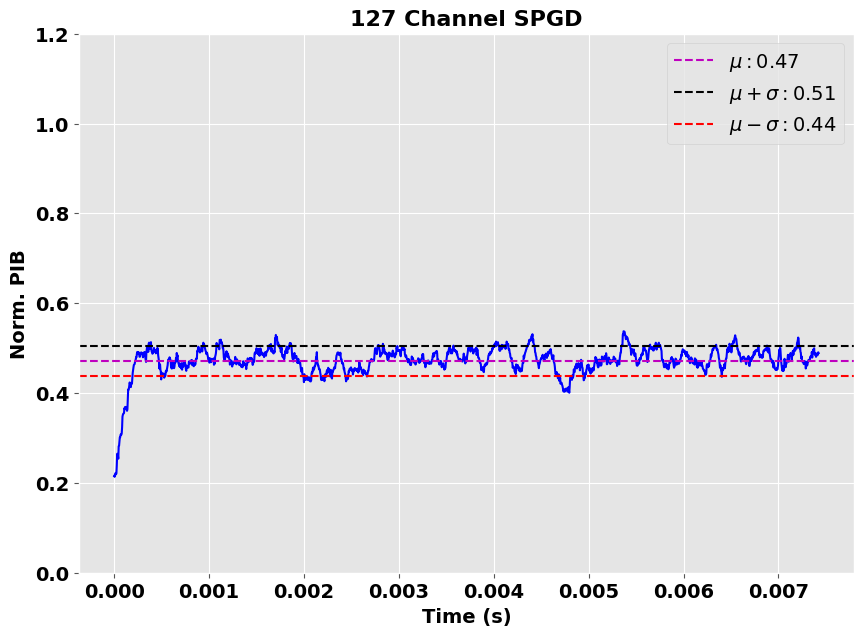

In [ ]:
plot_pib(pib_val,pib_n, title='127 Channel SPGD', t=t[0:len(pib_val)])

In [ ]:
%%time
U_in,Up,coord = TiledAperture_2(im_size,pix_size,n_channel,np.zeros(n_channel),n_screens,Kvar,Z,trans_pn,atm,amp_v,g_amp,a,d)


Prop time:  0.1739063262939453
CPU times: user 689 ms, sys: 290 ms, total: 979 ms
Wall time: 1.18 s


In [ ]:
%%time
I = get_ff(Up,coord,0*np.random.randn(n_channel))
PIB(I,im_size/2, im_size/2,rp,pix_size),masked_PIB(I,im_size/2, im_size/2,0.5*rp,pix_size)

CPU times: user 564 ms, sys: 145 ms, total: 710 ms
Wall time: 713 ms


(4999.664040577367, 8779.702257853796)

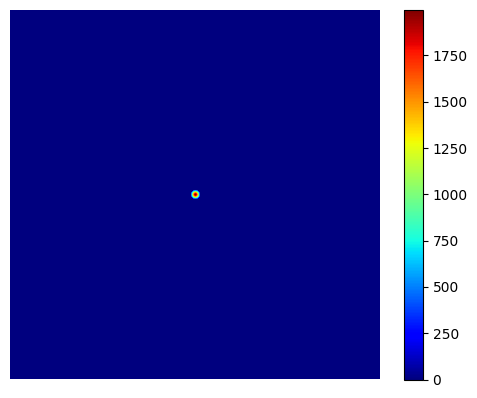

In [ ]:
xp=200
I_in = np.abs(U_in[im_size//2-xp:im_size//2+xp,im_size//2-xp:im_size//2+xp])
plt.imshow(I_in,cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

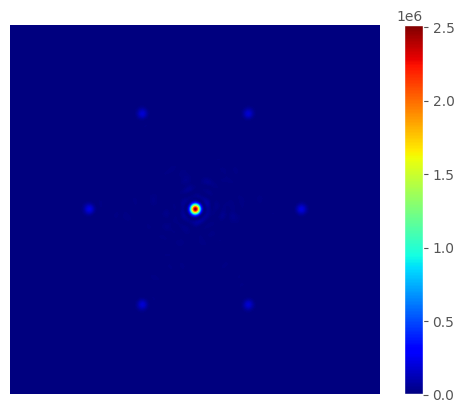

In [ ]:
plt.imshow(np.abs(I),cmap='jet')
plt.colorbar()
plt.axis('off')
plt.show()

In [ ]:
# import cv2
# import numpy as np
# import glob

# img_array = []
# size = (6000,4200)
# out = cv2.VideoWriter('19_ch_ol.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
# for filename in glob.glob('./19 ch ol/*.png'):
#     img = cv2.imread(filename)
#     height, width, layers = img.shape
#     size = (width,height)
#     # img_array.append(img)
#     out.write(img)


# # out = cv2.VideoWriter('19_ch_ol.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

# # for i in range(len(img_array)):
# #     out.write(img_array[i])
# out.release()